In [ ]:
"""
Module Name: HMC.ipynb

Description:
    Making a list of distributions and functions for use in numerical sampling and analysis of approximate convergence. 

Author: John Gallagher
Created: 2025-06-03
Last Modified: 
Version: 1.0.0

Dependencies:
    - numpy
    - scipy
    - matplotlib.pyplot
"""
import numpy as np
import pandas as pd
from scipy.special import gamma
import matplotlib.pyplot as plt
np.random.seed(1234)  # For reproducibility

In [ ]:
Some functio

In [168]:
def nongauss_f(x):
    """Non-gaussian target distribution."""
    return np.exp(-x**2 * (2 + np.sin(5*x) + np.sin(2*x)))

def gauss_f(x):
    """Gaussian target distribution."""
    return np.exp(-x**2)
def t_dist_f(x, df=3):
    """t-distribution target distribution."""
    return gamma((df + 1) / 2) / (np.sqrt(df * np.pi) * gamma(df / 2)) * (1 + x**2 / df)**(-(df + 1) / 2)

In [ ]:
def metropolis_step(x, sigma, function):
    """ Perform a single Metropolis-Hastings step.
    Args:
        x (float): Current state of the chain.
        sigma (float): Step size for the proposal distribution.
        function (callable): Target distribution function.
    
    Returns:  
        tuple: A tuple containing the new state and a boolean indicating whether the step was accepted.
    """

    proposed_x = np.random.normal(x, sigma)
    alpha = min(1, function(proposed_x)/function(x)) #why does this fraction work? Base case is we draw from the center of distributions and we want more information on the curvature.  The smaller probabilties (lower values) are associated with getting more information about the smaller regions. 
    u = np.random.uniform()
    if u < alpha:
        value = proposed_x
        accepted = True
    else:
        value = x
        accepted = False
    return value, accepted
def metropolis_sampler(initial_val, function, n=1000, sigma = 1):
    """
    Perform Metropolis-Hastings sampling.

    Args:
        initial_val (float): Initial value for the chain.
        function (callable): Target distribution function.
        n (int): Number of samples to generate.
        sigma (float): Step size for the proposal distribution.
    
    Returns:
        list: List of tuples containing sampled values and acceptance status.
    """

    results = []
    current_state = initial_val
    for i in range(0, n):
        out = metropolis_step(current_state, sigma, function)
        current_state = out[0]
        results.append(out)
    return results

def plot_results(self, x_range=(-11, 11), n_points=10000, bins=50):
    """
    Plot the sampling results against the target distribution.
    
    Args:
        x_range (tuple): Range of x values for plotting
        n_points (int): Number of points for target function curve
        bins (int): Number of histogram bins
    """
    if self.samples is None:
        raise ValueError("No samples available. Run sample() first.")
        
    fig, ax1 = plt.subplots()
    
    # Plot histogram of accepted samples
    ax1.hist(self.accepted['value'], bins=bins)
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('x-Value')
    ax1.set_title('Resulting Accepted Distribution vs Target Function')
    
    # Plot target distribution
    ax2 = ax1.twinx()
    x_vals = np.linspace(x_range[0], x_range[1], n_points)
    y_vals = [self.target_function(x) for x in x_vals]
    ax2.plot(x_vals, y_vals, 'r-', label='Target Function')
    ax2.set_ylabel('Target Function Value')
    ax2.set_ylim(0, 1)
    
    plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/cf/2c70vlmd4zb0rmx_c3fdlmx00000gn/T/ipykernel_11481/2484756677.py:16: SyntaxWarning: invalid escape sequence '\s'
  '$f(x) = exp{[(-x^2)(2 + \sin{(5x)} + \sin{(2x))]}}$' )


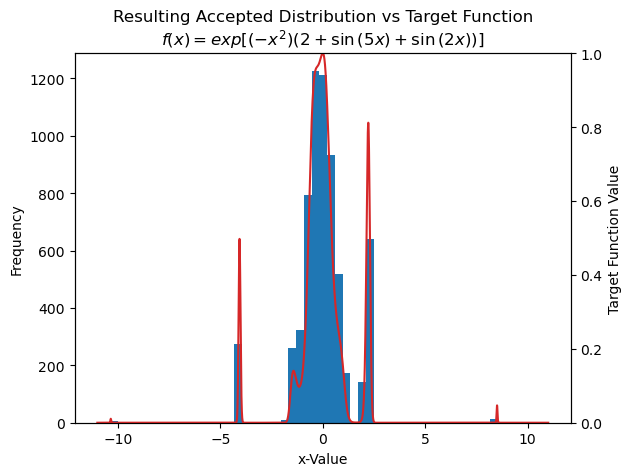

In [175]:
n = 100000
sigma = 12
sample = metropolis_sampler(0.1, nongauss_f, n = n,sigma=sigma)
data = pd.DataFrame(sample)
accepted = data[data[1]==True]
xval = np.linspace(-11,11, 10000)
yval = nongauss_f(xval)
fig, plt1 = plt.subplots()

# First y-axis with histogram
plt1.hist(accepted[0],bins=50)
plt1.set_ylabel('Frequency')
plt1.set_xlabel('x-Value')
plt1.set_title('Resulting Accepted Distribution vs Target Function'
               '\n' 
               '$f(x) = exp{[(-x^2)(2 + \sin{(5x)} + \sin{(2x))]}}$' )

# Second y-axis with target distribution
color = 'tab:red'
plt2 = plt1.twinx()
plt2.set_ylabel('Target Function Value')
plt2.set_ylim(0,1)
plt2.plot(xval, yval, label='Target Function', color = color)

In [ ]:
def leapfrog_step(t,  q, p, sigma, function, h=0.1):
    """
    Perform a single Leap-Frog step for symplectic integration.

    Args:
        t (float): Current time.
        dt (float): Time step for the integration.
        q (np.ndarray): Current state position vector.
        p (np.ndarray): Current state momentum vector.
        sigma (float): Standard deviation.
        function (callable): Target distribution function.

    Returns:
        tuple: A tuple containing the new state after the Symplectic Euler step.
    """
    # Mass matrix inverse (1/M = 1/sigma^2)
    mass_inv = 1. / (sigma**2)

    # Kinetic energy term
    # Half step for position 0.t*dt*K(t, x)
    q_half = q + 0.5 * h *mass_inv * p
    # Potential energy term
    # V(t,x) = - log(target_function(x))
    # Full step for momentum
    p_full = p + h * - gradient_term np.log(function(q_half))
    # Full step for position
    q_full = q_half + 0.5 * h * mass_inv * p_full
    return q_full, p_full
test0, test1 = leapfrog_step(1, 0.1, 0.2, 12, nongauss_f, h=0.1)

In [ ]:
def Hamiltonian(q, p, function, sigma=1.):
    """
    Compute the Hamiltonian of a system given position and momentum.

    Args:
        q (np.ndarray): Position vector.
        p (np.ndarray): Momentum vector.
        sigma (float): Standard deviation.

    Returns:
        float: The Hamiltonian value.
    """
    # Assuming M = sigma^2 * I, where I is the identity matrix
    sigma = 1  # This can be adjusted as needed
    kinetic_energy = 0.5  * p**2 / (sigma ** 2)
    potential_energy = -np.log(function(q))  # Assuming q is the position vector
    return kinetic_energy + potential_energy

def HMC_step(t, y, sigma, function, h=0.02):
    """
    Perform a single Hamiltonian Monte Carlo step.

    Args:
        y (float): Current state of the chain.
        sigma (float): Step size for the proposal distribution.
        function (callable): Target distribution function.
        h (float): Step size for the leapfrog integration.

    Returns:
        tuple: A tuple containing the new state and a boolean indicating whether the step was accepted.
    """
    # initial state
    q_initial = y
    p_initial = np.random.normal(0, sigma)
    
    # Perform a leapfrog step for proposed step
    q_proposed, p_proposed = leapfrog_step(t, q_initial, p_initial, sigma, function, h)
    
    # Compute the Hamiltonian for both initial and proposed states
    Current_Hamiltonian = Hamiltonian(q_initial, p_initial, function, sigma)
    Proposed_Hamiltonian = Hamiltonian(q_proposed, p_proposed, function, sigma)
    # Compute the acceptance probability
    alpha = min(1, np.exp(Current_Hamiltonian-Proposed_Hamiltonian))
    
    # Accept or reject the proposed step
    u = np.random.uniform()
    if u < alpha:
        return q_proposed, True
    return q_initial, False

def HMC_sampler(initial_val, function, n=1000, sigma=1., h = 0.1):
    """
    Perform Hamiltonian Monte Carlo sampling.

    Args:
        initial_val (float): Initial value for the chain.
        function (callable): Target distribution function.
        n (int): Number of samples to generate.
        sigma (float): Step size for the proposal distribution.

    Returns:
        list: List of tuples containing sampled values and acceptance status.
    """
    results = []
    current_state = initial_val
    for i in range(n):
        out = HMC_step(1, current_state, sigma, function, h)
        current_state = out[0]
        results.append(out)
    return results

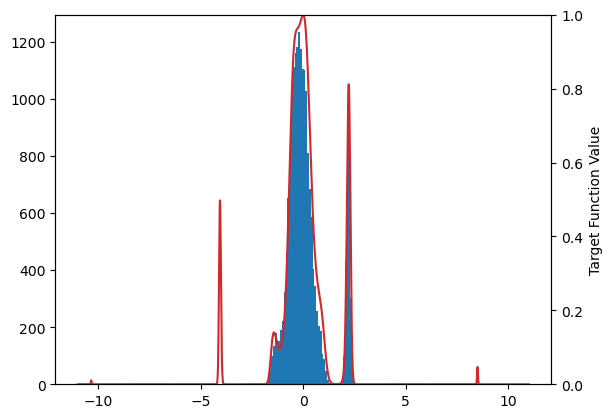

In [174]:
# Test the sampler
n = 30000
sigma = 1.
initial_val = 0.1
h = 0.5
samples = HMC_sampler(initial_val, nongauss_f, n=n, sigma=sigma, h=h)
# samples = metropolis_sampler(0.1, nongauss_f, n = n,sigma=sigma)

# Plot results
import pandas as pd
data = pd.DataFrame(samples)
accepted = data[data[1]==True]
fig, plt1 = plt.subplots()
plt1.hist(accepted[0], bins=50)
# plt1.title('HMC Sampling Results')
# plt1.xlabel('Value')
# plt1.ylabel('Frequency')

# Second y-axis with target distribution
yval = nongauss_f(xval)
color = 'tab:red'
plt2 = plt1.twinx()
plt2.set_ylabel('Target Function Value')
plt2.set_ylim(0,1)
plt2.plot(xval, yval, label='Target Function', color = color)
plt.show()